<a href="https://colab.research.google.com/github/faishalwickson/COVID-Cases-Forecasting-Based-on-Mobility-Using-Prophet/blob/main/covid_mobility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# access API
import requests
import urllib.request
from bs4 import BeautifulSoup
import re
import json

# BPS Java-Bali Covid Cases

## Extract

In [2]:
# sub region list
province = ['DKI_JAKARTA', 'JAWA_BARAT', 'JAWA_TIMUR', 'JAWA_TENGAH', 'SULAWESI_SELATAN',
            'BANTEN', 'NUSA_TENGGARA_BARAT', 'BALI', 'PAPUA', 'KALIMANTAN_SELATAN',
            'SUMATERA_BARAT', 'SUMATERA_SELATAN', 'KALIMANTAN_TENGAH', 'KALIMANTAN_TIMUR',
            'SUMATERA_UTARA', 'DAERAH_ISTIMEWA_YOGYAKARTA', 'KALIMANTAN_UTARA',
            'KEPULAUAN_RIAU', 'KALIMANTAN_BARAT', 'SULAWESI_TENGGARA', 'LAMPUNG',
            'SULAWESI_UTARA', 'SULAWESI_TENGAH', 'RIAU', 'PAPUA_BARAT', 'SULAWESI_BARAT',
            'JAMBI', 'GORONTALO', 'MALUKU_UTARA', 'MALUKU', 'KEPULAUAN_BANGKA_BELITUNG',
            'ACEH', 'BENGKULU', 'NUSA_TENGGARA_TIMUR']

# dummy arrays
resp = [None]*len(province)
cov_data = []
data_covid = []
cov_raw = {}

In [3]:
# access API
df = []
for i in range(0, len(province)):
  resp = requests.get('https://data.covid19.go.id/public/api/prov_detail_'+province[i]+'.json')
  cov_raw = resp.json()
  covid = pd.DataFrame(cov_raw['list_perkembangan'])
  covid['province'] = [province[i]]*len(covid)
  df.append(covid)
  
results = pd.concat(df, ignore_index=True) # concatenate data of each province

# convert to date time
results['tanggal'] = pd.to_datetime(results['tanggal']*1e6, unit='ns')

## Transform

In [4]:
# tidy up data
results_tidy = (results.drop(columns=[item for item in results.columns if item.startswith('AKUMULASI') or item.startswith('DIRAWAT')])
                  .rename(columns=str.lower)
                  .rename(columns={'kasus':'y',
                                   'tanggal': 'ds',
                                   'meninggal': 'death',
                                   'sembuh': 'recovered'}))

In [5]:
# Filter the country region
for region in ['DKI_JAKARTA', 'JAWA_BARAT', 'BANTEN', 'JAWA_TENGAH','JAWA_TIMUR',
               'DAERAH_ISTIMEWA_YOGYAKARTA', 'BALI']:
  temp = results_tidy.loc[results_tidy['province'].isin([region])]
  temp = temp.drop(['province'], axis=1) # drop column
  
  # saving dataframe
  if region in ['DKI_JAKARTA']: df_jkt = temp
  elif region in ['JAWA_BARAT']: df_jbr = temp
  elif region in ['BANTEN']: df_bnt = temp
  elif region in ['JAWA_TENGAH']: df_jtg = temp
  elif region in ['JAWA_TIMUR']: df_jtm = temp
  elif region in ['DAERAH_ISTIMEWA_YOGYAKARTA']: df_diy = temp
  elif region in ['BALI']: df_bli = temp

# Google Community Mobility

## Extract

In [6]:
# Import data
dataset = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv', low_memory=False)

## Transform

In [7]:
# Filter the country region
dataset = dataset.loc[dataset['country_region'].isin(["Indonesia"])]

# dropping unnecessary fields
dataset = dataset.drop(['country_region_code', 'country_region',
                        'sub_region_2','metro_area', 'iso_3166_2_code',
                        'census_fips_code', 'place_id'], axis=1)

# Rename some columns
dataset = dataset.rename(columns={'date': 'ds',
                                  'retail_and_recreation_percent_change_from_baseline': 'retail_recreation',
                                  'grocery_and_pharmacy_percent_change_from_baseline': 'grocery_pharmacy',
                                  'parks_percent_change_from_baseline': 'parks',
                                  'transit_stations_percent_change_from_baseline': 'transit_stations',
                                  'workplaces_percent_change_from_baseline': 'workplaces',
                                  'residential_percent_change_from_baseline': 'residential'})

# Replace null values
dataset['sub_region_1'].fillna('')
for column in ['retail_recreation', 'grocery_pharmacy', 'parks', 
               'transit_stations', 'workplaces', 'residential']:
  dataset[column] = dataset[column].fillna(0)

# Adding information on country level
dataset.loc[dataset['sub_region_1'] == '', 'sub_region_1'] = '<All Regions>'

# Flatten the pivot table and reset the index of the dataframe 
dataset = pd.DataFrame(dataset.to_records()).reset_index(drop=True)
dataset.drop('index', inplace=True, axis=1)

# Convert data type for 'ds' to datetime
dataset['ds'] = pd.to_datetime(dataset['ds'], unit='ns')

In [8]:
# Filter the country region
for region in ['Jakarta', 'West Java', 'Banten', 'Central Java','East Java', 
               'Special Region of Yogyakarta', 'Bali']:
  temp = dataset.loc[dataset['sub_region_1'].isin([region])]
  temp = temp.drop(['sub_region_1'], axis=1) # drop column
  
  # saving dataframe
  if region in ['Jakarta']: jkt = temp 
  elif region in ['West Java']: jbr = temp
  elif region in ['Banten']: bnt = temp
  elif region in ['Central Java']: jtg = temp
  elif region in ['East Java']: jtm = temp
  elif region in ['Special Region of Yogyakarta']: diy = temp
  elif region in ['Bali']: bli = temp

# Data Integration

In [9]:
# Merge dataset per province with google mobility
df_jkt = df_jkt.merge(jkt, how='inner', on='ds')
df_jbr = df_jbr.merge(jbr, how='inner', on='ds')
df_bnt = df_bnt.merge(bnt, how='inner', on='ds')
df_jtg = df_jtg.merge(jtg, how='inner', on='ds')
df_diy = df_diy.merge(diy, how='inner', on='ds')
df_jtm = df_jtm.merge(jtm, how='inner', on='ds')
df_bli = df_bli.merge(bli, how='inner', on='ds')

# Model Input

In [33]:
df = df_jkt.copy()
regr = ['parks', 'workplaces', 'grocery_pharmacy', 'retail_recreation',
        'transit_stations', 'residential'] #, 'walking', 'driving']
period = 30 # forecast period for next few days
h = 7 # moving average and holiday period
fcst = 'last period'

In [34]:
for i, column in enumerate(df.columns[4:]):
    name = 'MA_'+column
    df[name] = df[column].rolling(h).mean()
    regr[i] = name
    
df['y'] = df['y'].rolling(h).mean()
df = df[12:].reset_index(drop=True)

if fcst == 'last period':
  test = pd.concat([df, df[-1*period:]], ignore_index=True)

# Data Decomposition

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from matplotlib import rcParams
from cycler import cycler

temp = df[['ds', 'y']]
temp = temp.set_index('ds')
# temp = temp
# Decompose and plot
# decomposed = seasonal_decompose(temp, model='multiplicative')
# decomposed.plot();

# Data Normalization

In [36]:
from scipy import interpolate
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
import plotly.graph_objs as go

import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import matplotlib
import warnings
warnings.warn("Warning...........Message")
from pandas.tseries.offsets import MonthEnd
import matplotlib.dates as mdates

from IPython.core.pylabtools import figsize
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from collections import namedtuple
from plotly.subplots import make_subplots

rcParams['figure.figsize'] = 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
rcParams['lines.linewidth'] = 2.5

Lambda is: 0.10206250984079784


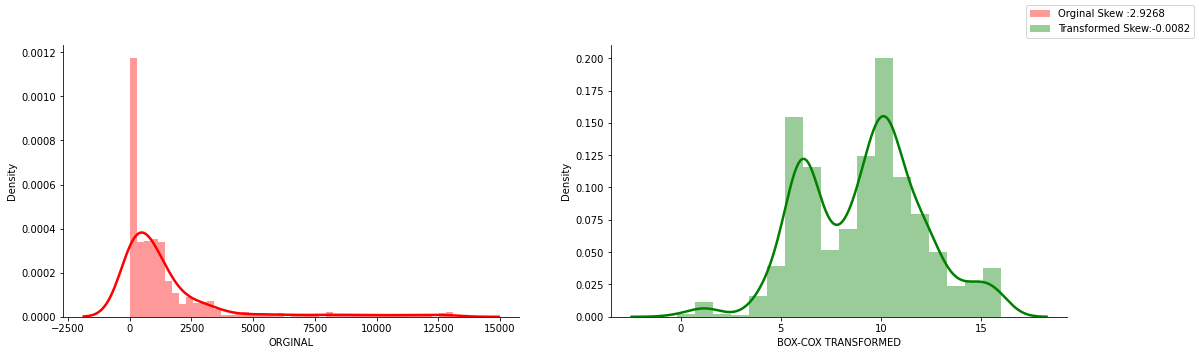

In [37]:
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
from scipy.special import inv_boxcox

data = df[['y']]
# pt = PowerTransformer(method='yeo-johnson')
# pt.fit(data)
# data = pt.transform(data)
data, lam = boxcox(df['y'])
print('Lambda is:', lam)

fig,ax = plt.subplots(1,2)
sns.distplot(df['y'], label= "Orginal Skew :{0}".format(np.round(skew(df['y']),4)), color="r", ax=ax[0], axlabel="ORGINAL")
sns.distplot(data, label= "Transformed Skew:{0}".format(np.round(skew(data),4)), color="g", ax=ax[1], axlabel="BOX-COX TRANSFORMED")
fig.legend()
plt.show()
df['y'] = data

# Raw modelling

In [15]:
from prophet import Prophet
from prophet import hdays
from prophet.diagnostics import cross_validation
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

import seaborn as sns

import logging
logging.getLogger().setLevel(logging.ERROR)

In [16]:
holidays_id = hdays.Indonesia()
holidays_id._populate(2020)
holidays_id._populate(2021)
holidays_id._populate(2022)
holiday = pd.DataFrame([holidays_id], index=['holiday']).T.rename_axis('ds').reset_index()
holiday['lower_window'] = 0
holiday['upper_window'] = h

In [17]:
model = Prophet(changepoint_prior_scale = 0.8,
                changepoint_range = 0.95,
                seasonality_prior_scale = 10,
                seasonality_mode = 'additive',
                holidays = holiday)

# add regressors to model
for regressor in regr:
  model.add_regressor(regressor, mode= 'multiplicative')

# fit the model
model.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7xr19nkg/wpwxq0v6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7xr19nkg/dw68g3c8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74892', 'data', 'file=/tmp/tmp7xr19nkg/wpwxq0v6.json', 'init=/tmp/tmp7xr19nkg/dw68g3c8.json', 'output', 'file=/tmp/tmpb589d9jl/prophet_model-20220819071202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:12:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:12:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [18]:
# create a dataframe holding dates for forecasting
# periods length equal with test
future = model.make_future_dataframe(periods=period, freq='D')

# add future fields for regressors
for regressor in regr:
  future[regressor] = test[regressor]
  
# create the forecast object
forecast = model.predict(future)

# invers forecast to actual scale using retransform boxcox
for column in ['yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_upper', 'trend_lower']:
  forecast[column] = inv_boxcox(forecast[[column]], lam)
model.history['y'] = inv_boxcox(model.history[['y']], lam)

# Retransform using YJ
#   forecast[column] = pt.inverse_transform(forecast[[column]])
# m1.history['y'] = pt.inverse_transform(m1.history[['y']])
# df['y'] = pt.inverse_transform(df[['y']])

In [19]:
from prophet.plot import plot_plotly, plot_components_plotly
# Visualize output
plot_plotly(model, forecast)

In [20]:
plot_components_plotly(model,forecast)

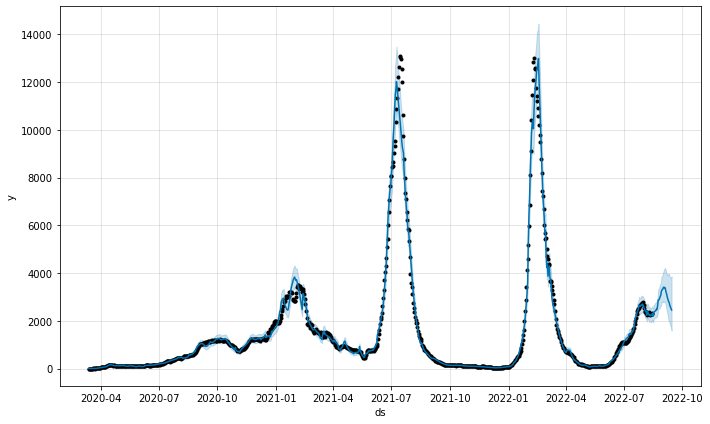

In [21]:
fig = model.plot(forecast)
plt.show()

In [22]:
fig = px.line(x=model.history['ds'], y=[model.history['y'], forecast['yhat'][:-1*period]], title='actual v forecast')
fig.show()

## Evaluation Metrics

In [23]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
def MAPE(y_true, y_pred): 
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / np.maximum(np.ones(len(y_true)), np.abs(y_true))))
def mdape(y_true, y_pred): 
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.median(np.abs((y_true - y_pred) / np.maximum(np.ones(len(y_true)), np.abs(y_true))))
    
# rmsle train
if forecast['yhat'][:-1*period].min() > 0:
  rmsle = mean_squared_log_error(y_true=model.history['y'],
                                     y_pred=forecast['yhat'][:-1*period],
                                     squared=False)
  print('RMSLE:', "{:.4f}".format(rmsle))
else: print('RMSLE: -' )

# rmse train
rmse = mean_squared_error(y_true=model.history['y'],
                                y_pred=forecast['yhat'][:-1*period],
                                squared=False)
print('RMSE:', "{:.4f}".format(rmse))

# mape train
mape = MAPE(y_true=model.history['y'],
                  y_pred=forecast['yhat'][:-1*period])
print('MAPE:', "{:.4f}".format(mape))

RMSLE: 0.1143
RMSE: 367.8757
MAPE: 0.0918


## Feature Importance

In [24]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,y,death,recovered,retail_recreation,grocery_pharmacy,parks,transit_stations,workplaces,residential,MA_retail_recreation,MA_grocery_pharmacy,MA_parks,MA_transit_stations,MA_workplaces,MA_residential
y,1.000000,0.591467,0.667371,-0.056996,0.039996,0.004293,-0.051814,-0.014043,0.024601,-0.068258,0.044935,-0.007935,-0.072823,-0.034673,0.044634
death,0.591467,1.000000,0.653775,-0.297252,-0.126146,-0.223905,-0.324262,-0.272643,0.275107,-0.302442,-0.127612,-0.231428,-0.326416,-0.339220,0.304365
recovered,0.667371,0.653775,1.000000,-0.109912,0.027006,0.011748,-0.156645,-0.069266,0.132206,-0.106464,0.045867,0.010280,-0.159678,-0.119790,0.168820
retail_recreation,-0.056996,-0.297252,-0.109912,1.000000,0.899745,0.796260,0.898671,0.543345,-0.772376,0.955205,0.870218,0.764243,0.914311,0.764454,-0.907594
grocery_pharmacy,0.039996,-0.126146,0.027006,0.899745,1.000000,0.671041,0.789789,0.483481,-0.684182,0.840561,0.907091,0.638399,0.766077,0.627172,-0.752270
parks,0.004293,-0.223905,0.011748,0.796260,0.671041,1.000000,0.707434,0.417806,-0.588728,0.794301,0.695255,0.961679,0.769066,0.672972,-0.736337
transit_stations,-0.051814,-0.324262,-0.156645,0.898671,0.789789,0.707434,1.000000,0.768959,-0.929965,0.899517,0.772606,0.732971,0.926239,0.783156,-0.911274
workplaces,-0.014043,-0.272643,-0.069266,0.543345,0.483481,0.417806,0.768959,1.000000,-0.791657,0.562164,0.443152,0.505583,0.595164,0.701019,-0.562648
residential,0.024601,0.275107,0.132206,-0.772376,-0.684182,-0.588728,-0.929965,-0.791657,1.000000,-0.796581,-0.683453,-0.625854,-0.810234,-0.641044,0.849230
MA_retail_recreation,-0.068258,-0.302442,-0.106464,0.955205,0.840561,0.794301,0.899517,0.562164,-0.796581,1.000000,0.915640,0.810892,0.962958,0.797108,-0.945093


In [25]:
beta = model.train_component_cols
b = model.params['beta'].tolist()
temp = []
for i in range(len(beta)):
  temp.append(b[0][i])
beta['beta'] = temp

In [26]:
from prophet.utilities import regressor_coefficients
regressor_coefficients(model).sort_values(by='coef', ascending = False)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
5,MA_residential,multiplicative,11.581748,0.017785,0.017785,0.017785
1,MA_grocery_pharmacy,multiplicative,-3.633344,0.007079,0.007079,0.007079
2,MA_parks,multiplicative,-40.780555,0.001129,0.001129,0.001129
4,MA_workplaces,multiplicative,-27.342793,0.000556,0.000556,0.000556
3,MA_transit_stations,multiplicative,-37.673654,-0.000333,-0.000333,-0.000333
0,MA_retail_recreation,multiplicative,-25.691229,-0.007402,-0.007402,-0.007402


## Time Lag

In [27]:
import scipy
print(scipy.__version__)

1.7.3


In [28]:
# !pip install --upgrade scipy

In [29]:
xx = 'jbr'
yy = 'jkt'

In [30]:
df2 = df_jbr.merge(df_jkt,on='ds',
                   suffixes=('_'+xx, '_'+yy),
                   how='inner')

In [31]:
# correlation lag
from scipy import signal

x = df2['y_'+xx]
y = df2['y_'+yy]

# Implementation of MATLAB xcorr(x,y) and comparision of result with example.
import scipy.signal as signal
import plotly.express as px

def xcorr(x,y):
    corr = signal.correlate(x-np.mean(x), y - np.mean(y), mode="full", method='auto') # coefficients of correlation
    lags = signal.correlation_lags(len(x), len(y), mode="full") # lags of correlation
    corr /= np.max(corr)
    maxlag = lags[np.argmax(corr)]
    minlag = lags[np.argmin(corr)]
    return maxlag, minlag, lags, corr

# maxlag, minlag, lags, c = xcorr(x,y)
# print('maximum correlation lag:', maxlag)
# print('minimum correlation lag', minlag)
# fig = px.line(x=lags, y=c, title='lag correlation')
# fig.show()

# Cross validation

In [ ]:
df_cv = cross_validation(model, initial='580 days', period='30 days', horizon='7 days')

INFO:fbprophet:Making 7 forecasts with cutoffs between 2021-11-23 00:00:00 and 2022-05-22 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
df_p = performance_metrics(df_cv, rolling_window=0)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,0.082889,0.287905,0.234803,0.080474,0.056896,0.571429
1,2 days,0.119270,0.345355,0.310490,0.130033,0.098133,0.142857
2,3 days,0.242176,0.492114,0.425159,0.192438,0.086606,0.285714
3,4 days,0.316375,0.562472,0.503552,0.184172,0.156335,0.000000
4,5 days,0.400758,0.633055,0.563081,0.210219,0.166002,0.000000
5,6 days,0.585736,0.765334,0.601260,0.184341,0.161722,0.142857
6,7 days,0.813953,0.902193,0.715256,0.231737,0.179604,0.142857


In [ ]:
df_p.mean()

horizon     4 days 00:00:00
mse                 0.36588
rmse               0.569775
mae                0.479086
mape               0.173345
mdape              0.129328
coverage           0.183673
dtype: object

In [ ]:
df_p.median()

horizon     4 days 00:00:00
mse                0.316375
rmse               0.562472
mae                0.503552
mape               0.184341
mdape              0.156335
coverage           0.142857
dtype: object

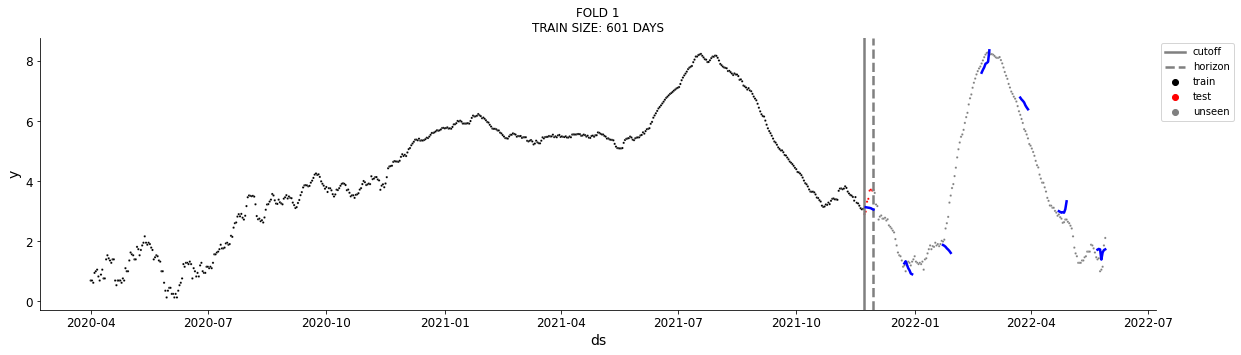

mape: 0.12248901642725286
mdape: 0.1563351026925385
rmsle 0.11145796773690711



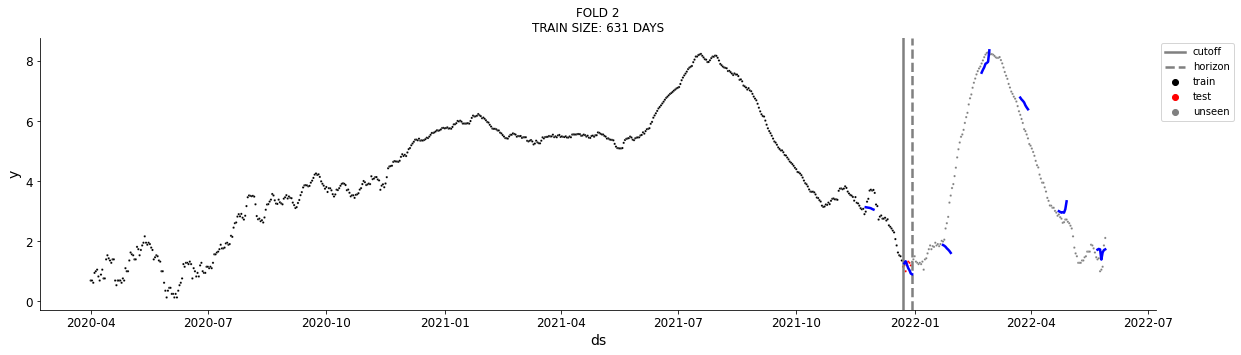

mape: 0.19087787543739412
mdape: 0.19376450292119277
rmsle 0.1225137811285519



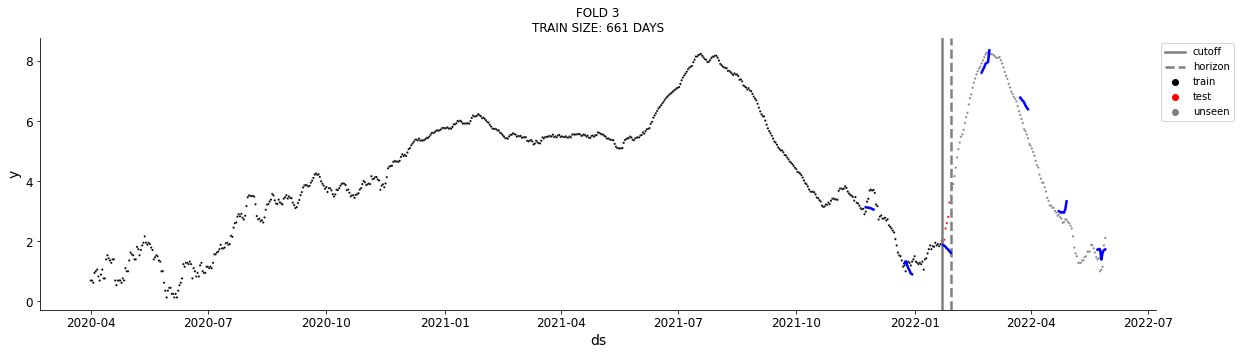

mape: 0.3068294938648686
mdape: 0.32217768590293666
rmsle 0.3271830940134988



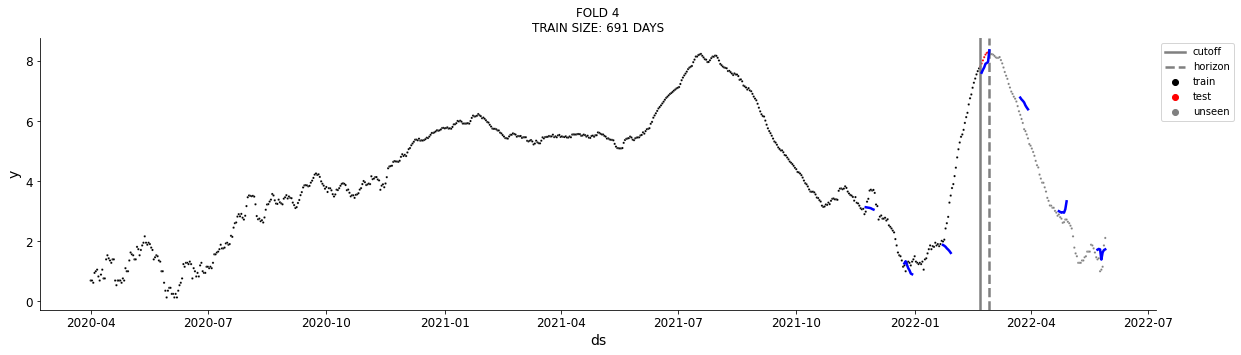

mape: 0.0347547684914934
mdape: 0.03858199003420351
rmsle 0.03298467362982621



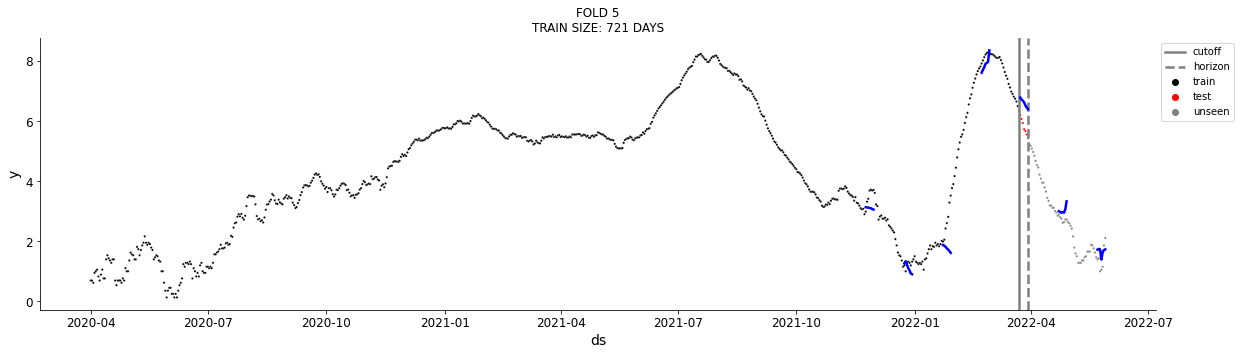

mape: 0.13861685400892662
mdape: 0.15109892613785178
rmsle 0.11342806585141997



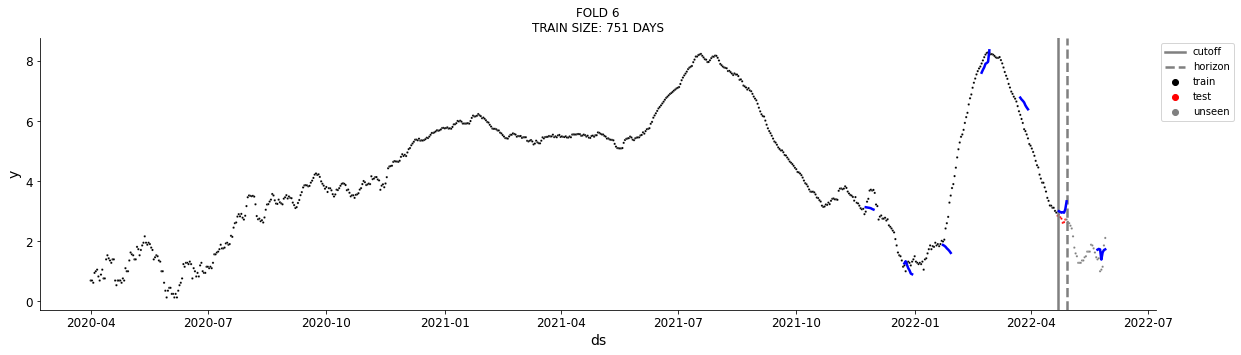

mape: 0.11075082499604659
mdape: 0.11911969411160839
rmsle 0.08587003971275502



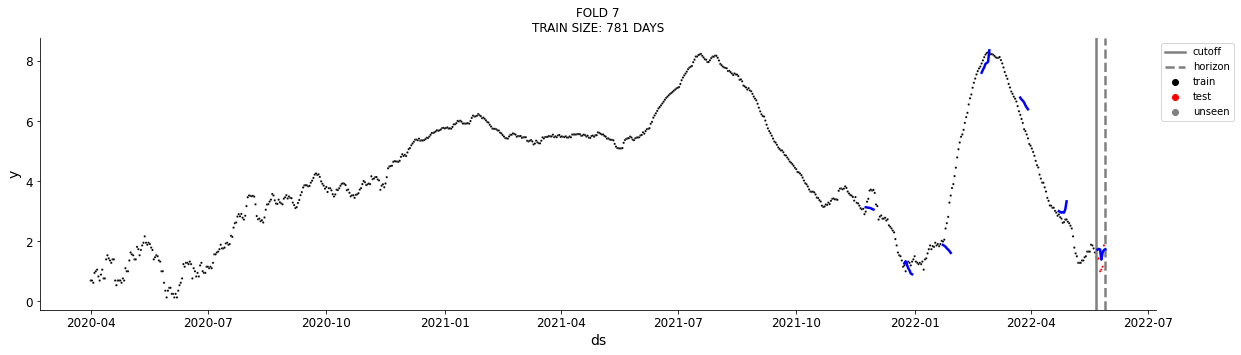

mape: 0.3090959740063789
mdape: 0.2306956944761372
rmsle 0.1728116428016113



In [ ]:
df_copy = df.copy()
df_cvf = df_cv.drop('y', axis=1)
df_copy = df_copy.merge(df_cvf, how='left', on='ds')
df_cutoff_horizon = df_cv.groupby('cutoff')[['ds']].max()

from sklearn.metrics import mean_absolute_percentage_error

for i, (cutoff, horizon) in enumerate(df_cutoff_horizon.iterrows()):
    horizon_cutoff = horizon['ds']
    df_copy['type'] = df_copy['ds'].apply(lambda date: 'train' if date < cutoff else
                                         'test' if date < horizon_cutoff else 'unseen')
    plt.figure(figsize=(20, 5))
    sns.scatterplot(x='ds', y='y', hue='type', s=5,
                   palette=['black', 'red', 'gray'],
                   data=df_copy)
    plt.axvline(x=cutoff, color='gray', label='cutoff')
    plt.axvline(x=horizon_cutoff, color='gray', ls='--', label='horizon')
    plt.plot(df_copy['ds'], df_copy['yhat'], color='b')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title(f"FOLD {i+1}\nTRAIN SIZE: {df_copy['type'].value_counts()['train']} DAYS")
    plt.show()
    cv_mape = df_cv.groupby('cutoff').apply(lambda x: mean_absolute_percentage_error(y_true=x['y'],
                                                         y_pred=x['yhat']))
    cv_mdape = df_cv.groupby('cutoff').apply(lambda x: mdape(y_true=x['y'],
                                                         y_pred=x['yhat']))
    cv_rmsle = df_cv.groupby('cutoff').apply(lambda x: mean_squared_log_error(y_true=x['y'],
                                                         y_pred=x['yhat'], squared=False))

    print('mape:', cv_mape[i])
    print('mdape:', cv_mdape[i])
    print('rmsle', cv_rmsle[i])
    print()

In [ ]:
cv_mape

cutoff
2021-11-23    0.122489
2021-12-23    0.190878
2022-01-22    0.306829
2022-02-21    0.034755
2022-03-23    0.138617
2022-04-22    0.110751
2022-05-22    0.309096
dtype: float64

In [ ]:
print('mape mean:', "{:.4f}".format(cv_mape.mean()))

mape mean: 0.1733


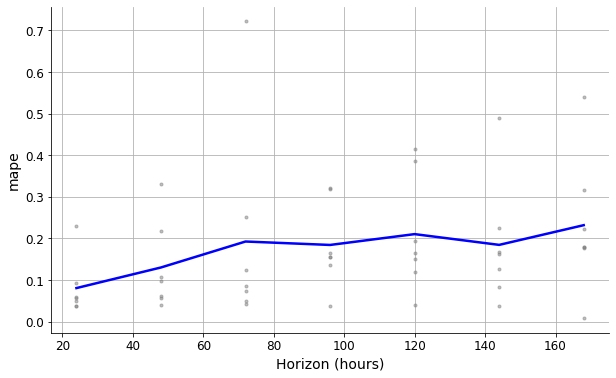

In [ ]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape', rolling_window=0)

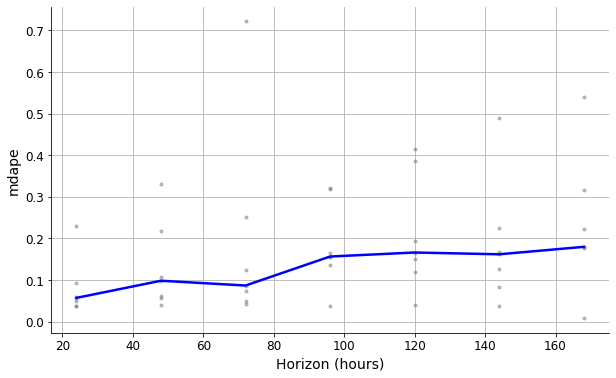

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='mdape')

# Hyperparameter Tuning

In [ ]:
from tqdm import tqdm
import itertools
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
# grid search parameters
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 0.8],
    'seasonality_prior_scale': [0.01, 1, 5, 10],
    'changepoint_range': [0.8, 0.9, 0.95]
}

In [ ]:
# generate all combinations of parameters
from sklearn.metrics import mean_absolute_error
all_params = [dict(zip(param_grid.keys(), v))
             for v in itertools.product(*param_grid.values())]
mapes = [] #store rmsles for each params
mdapes = [] #store rmsles for each params

min1 = 99
min2 = 99

bestmape = []
bestmdape = []

In [ ]:
# use cross validation to evaluate all parameters
for params in all_params:
    model = Prophet(**params,
                    holidays=holiday,
                    seasonality_mode= 'additive')
    
    for regressor in regr:
      model.add_regressor(regressor, mode='multiplicative')
    model.fit(df)
    
    #expanding window cross validation
    cv = cross_validation(model, initial='580 days',
                         period='30 days',
                         horizon='7 days',
                         parallel='processes')

    # evaluation metric
    hmape = cv.groupby('cutoff').apply(lambda x: mean_absolute_percentage_error(y_true=x['y'],
                                                                                y_pred=x['yhat']))
    hmdape = cv.groupby('cutoff').apply(lambda x: mdape(y_true=x['y'], y_pred=x['yhat']))
    mean_mape = hmape.mean()
    mean_mdape = hmdape.mean()
    mapes.append(mean_mape)
    mdapes.append(mean_mdape)

    if mean_mape < min1:
      min1 = mean_mape
      bestmape = cv
    if mean_mdape < min2:
      min2 = mean_mdape
      bestmdape = cv

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2021-11-23 00:00:00 and 2022-05-22 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fce399a4110>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2021-11-23 00:00:00 and 2022-05-22 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fce66f6c250>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2021-11-23 00:00:00 and 2022-05-22 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fce399a4d10>
INFO:fbprophet:Disabling daily seasonality. Run prop

In [ ]:
# find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results = tuning_results
tuning_results['mape'] = mapes
tuning_results['mdape'] = mdapes
tuning_results.sort_values(by='mape')

,changepoint_prior_scale,seasonality_prior_scale,changepoint_range,mape,mdape
48,0.250,0.01,0.80,0.173345,0.173111
60,0.500,0.01,0.80,0.180144,0.185192
72,0.800,0.01,0.80,0.192728,0.196263
39,0.100,1.00,0.80,0.224309,0.236001
45,0.100,10.00,0.80,0.224845,0.235780
...,...,...,...,...,...
10,0.001,10.00,0.90,0.925131,0.825277
7,0.001,5.00,0.90,0.927829,0.828409
3,0.001,1.00,0.80,0.985202,0.875422
4,0.001,1.00,0.90,1.000724,0.892026


In [ ]:
tuning_results.sort_values(by='mdape')

,changepoint_prior_scale,seasonality_prior_scale,changepoint_range,mape,mdape
48,0.250,0.01,0.80,0.173345,0.173111
60,0.500,0.01,0.80,0.180144,0.185192
72,0.800,0.01,0.80,0.192728,0.196263
50,0.250,0.01,0.95,0.230892,0.232990
42,0.100,5.00,0.80,0.225797,0.233833
...,...,...,...,...,...
10,0.001,10.00,0.90,0.925131,0.825277
7,0.001,5.00,0.90,0.927829,0.828409
3,0.001,1.00,0.80,0.985202,0.875422
4,0.001,1.00,0.90,1.000724,0.892026


In [ ]:
best_params_mape = all_params[np.argmin(mapes)]
best_params_mape

{'changepoint_prior_scale': 0.25,
 'changepoint_range': 0.8,
 'seasonality_prior_scale': 0.01}

In [ ]:
best_params_mdape = all_params[np.argmin(mdapes)]
best_params_mdape

{'changepoint_prior_scale': 0.25,
 'changepoint_range': 0.8,
 'seasonality_prior_scale': 0.01}

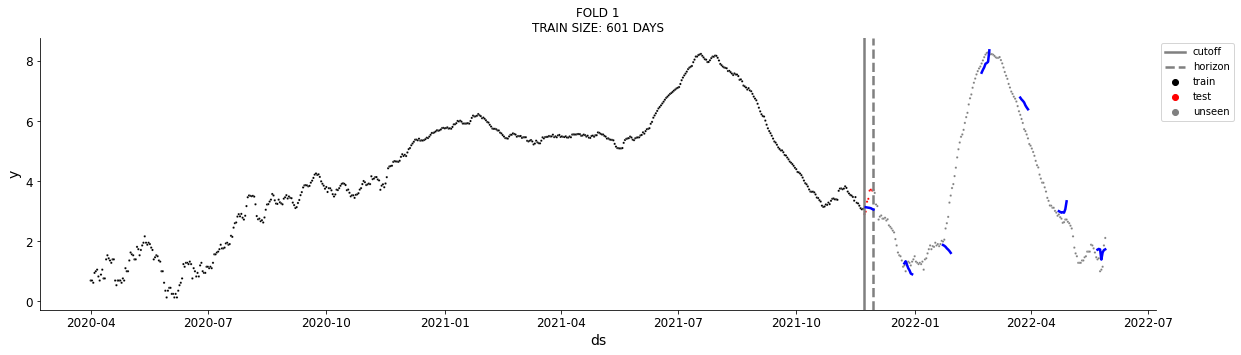

mape: 0.12248901642725286
mdape: 0.1563351026925385



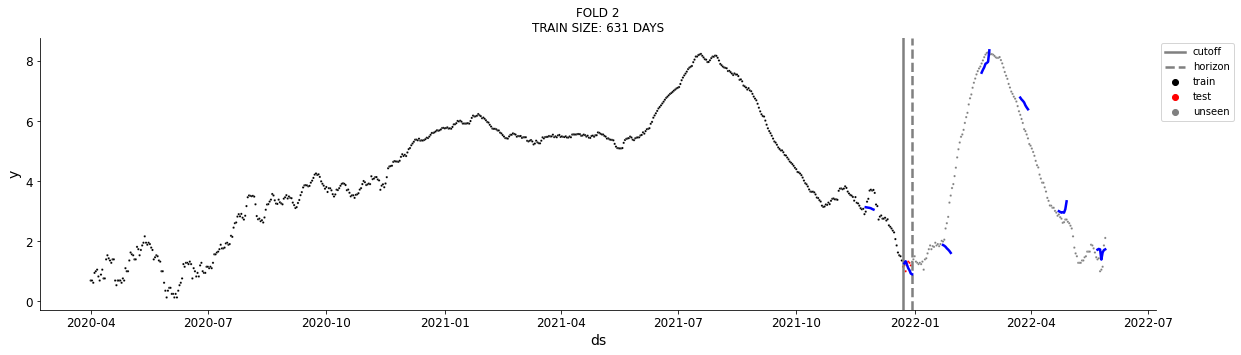

mape: 0.19087787543739412
mdape: 0.19376450292119277



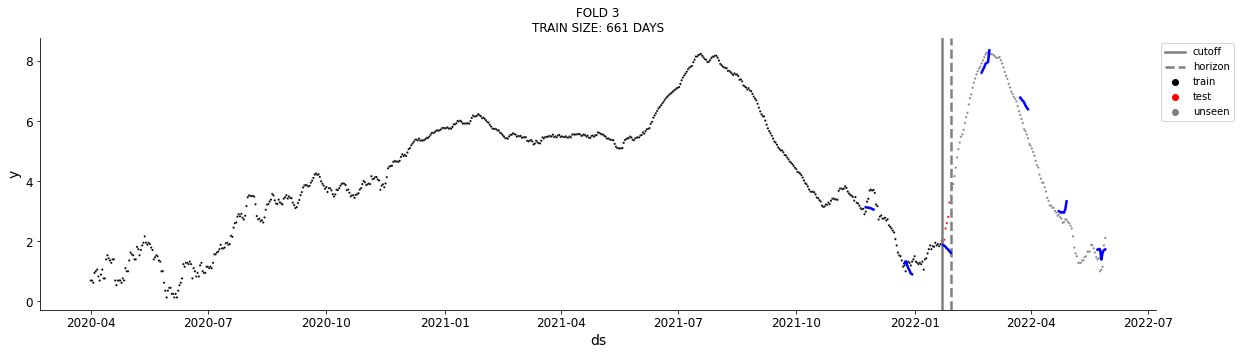

mape: 0.3068294938648686
mdape: 0.32217768590293666



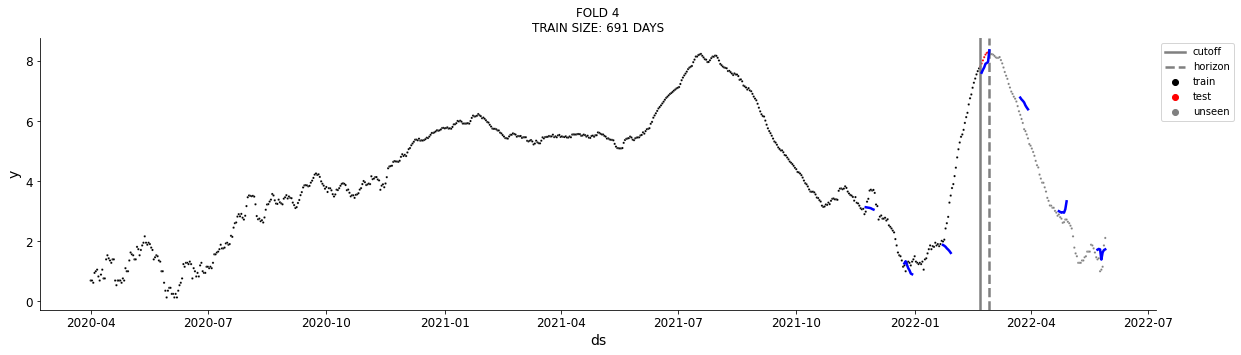

mape: 0.0347547684914934
mdape: 0.03858199003420351



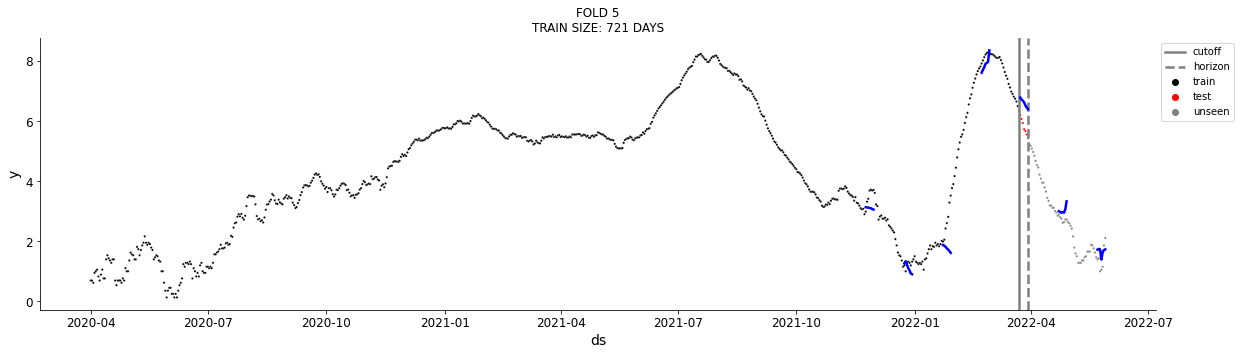

mape: 0.13861685400892662
mdape: 0.15109892613785178



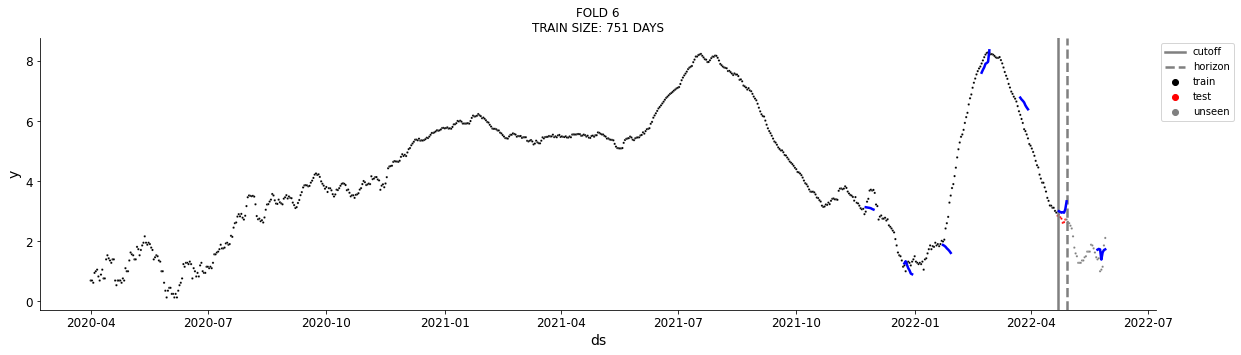

mape: 0.11075082499604659
mdape: 0.11911969411160839



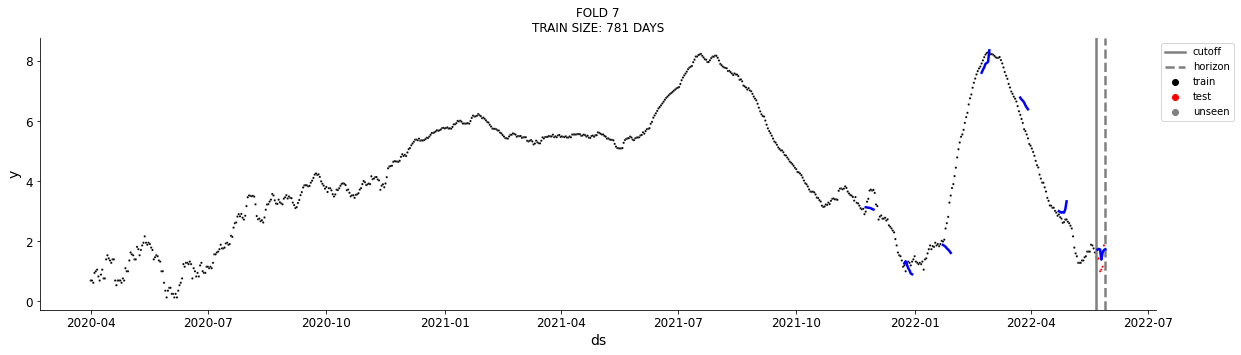

mape: 0.3090959740063789
mdape: 0.2306956944761372



In [ ]:
df_copy = df.copy()
df_cvf = bestmape.drop('y', axis=1)
df_copy = df_copy.merge(df_cvf, how='left', on='ds')
# df_copy['y'] = pt.inverse_transform(df_copy[['y']])
# df_copy['y'] = inv_boxcox(df_copy[['y']], lam)
# df_copy['yhat'] = pt.inverse_transform(df_copy[['yhat']])
df_cutoff_horizon = bestmape.groupby('cutoff')[['ds']].max()

from sklearn.metrics import mean_absolute_percentage_error

for i, (cutoff, horizon) in enumerate(df_cutoff_horizon.iterrows()):
    horizon_cutoff = horizon['ds']
    df_copy['type'] = df_copy['ds'].apply(lambda date: 'train' if date < cutoff else
                                         'test' if date < horizon_cutoff else 'unseen')
    plt.figure(figsize=(20, 5))
    sns.scatterplot(x='ds', y='y', hue='type', s=5,
                   palette=['black', 'red', 'gray'],
                   data=df_copy)
    plt.axvline(x=cutoff, color='gray', label='cutoff')
    plt.axvline(x=horizon_cutoff, color='gray', ls='--', label='horizon')
    plt.plot(df_copy['ds'], df_copy['yhat'], color='b')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title(f"FOLD {i+1}\nTRAIN SIZE: {df_copy['type'].value_counts()['train']} DAYS")
    plt.show()
    cv_mape = bestmape.groupby('cutoff').apply(lambda x: mean_absolute_percentage_error(y_true=x['y'],
                                                         y_pred=x['yhat']))
    cv_mdape = bestmape.groupby('cutoff').apply(lambda x: mdape(y_true=x['y'],
                                                         y_pred=x['yhat']))
    print('mape:', cv_mape[i])
    print('mdape:', cv_mdape[i])
    print()

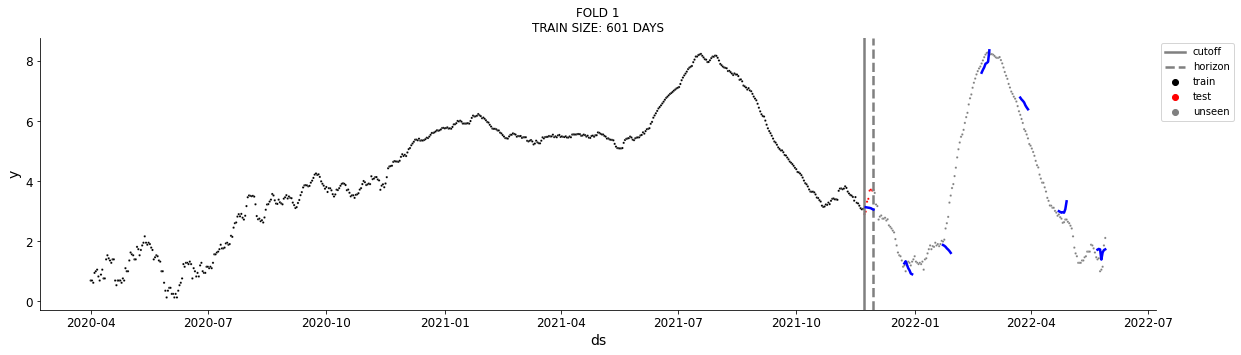

mape: 0.12248901642725286
mdape: 0.1563351026925385



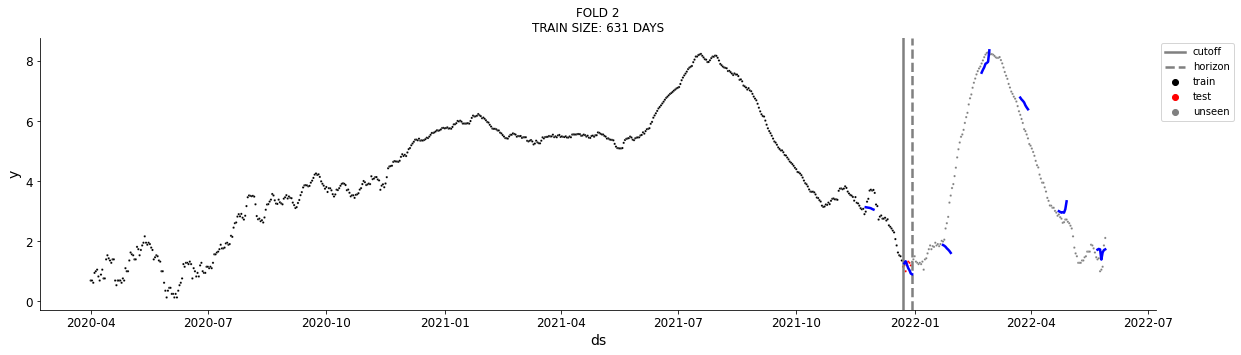

mape: 0.19087787543739412
mdape: 0.19376450292119277



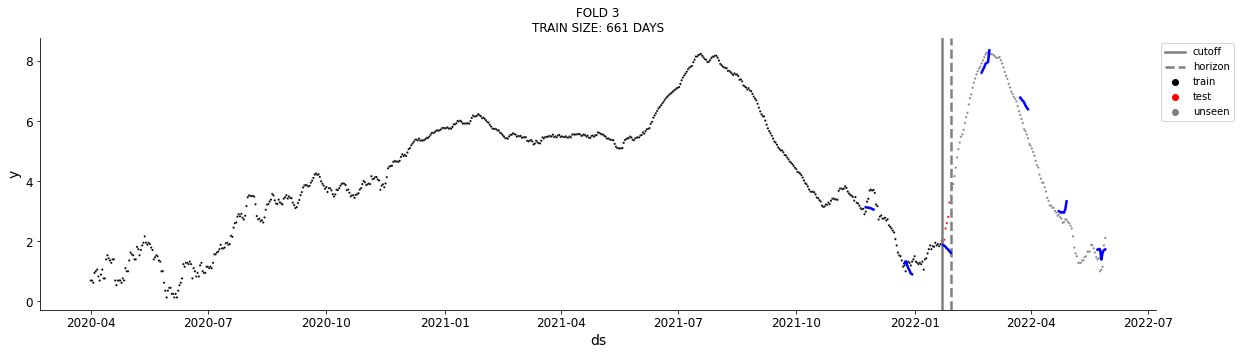

mape: 0.3068294938648686
mdape: 0.32217768590293666



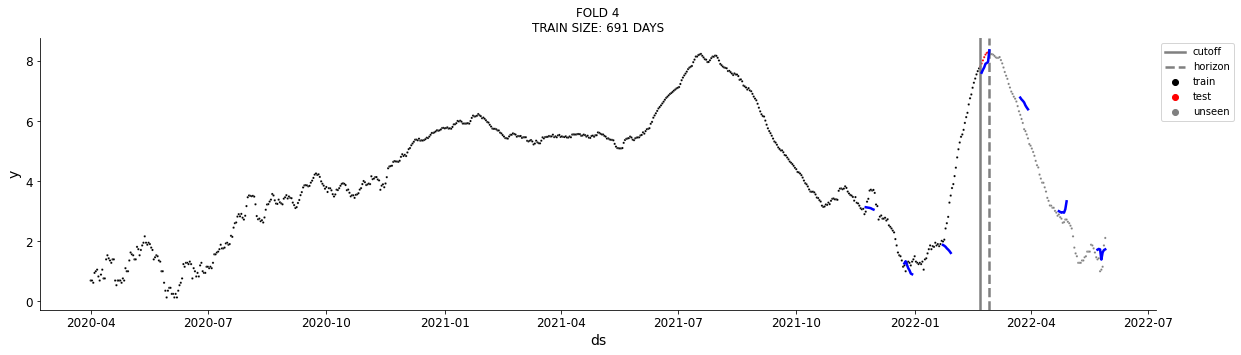

mape: 0.0347547684914934
mdape: 0.03858199003420351



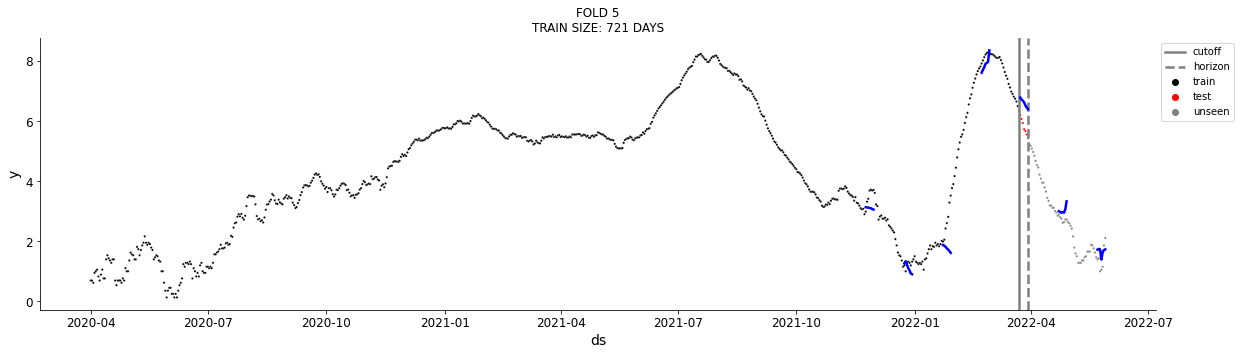

mape: 0.13861685400892662
mdape: 0.15109892613785178



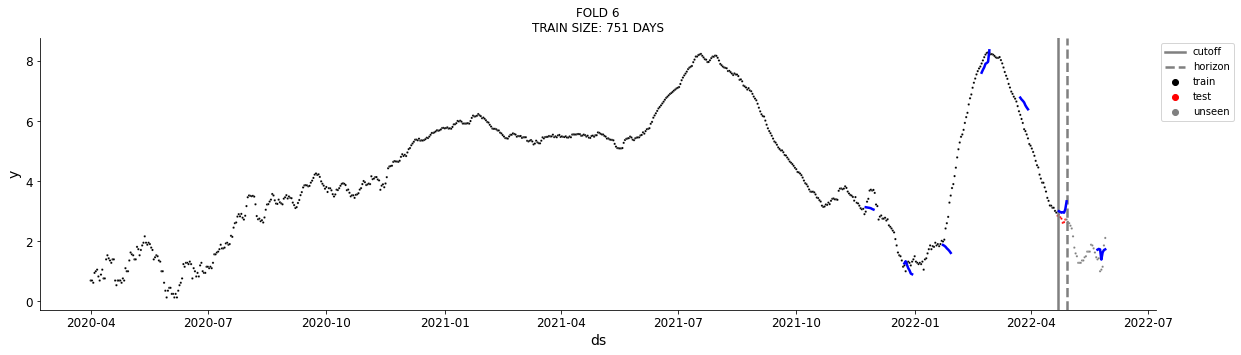

mape: 0.11075082499604659
mdape: 0.11911969411160839



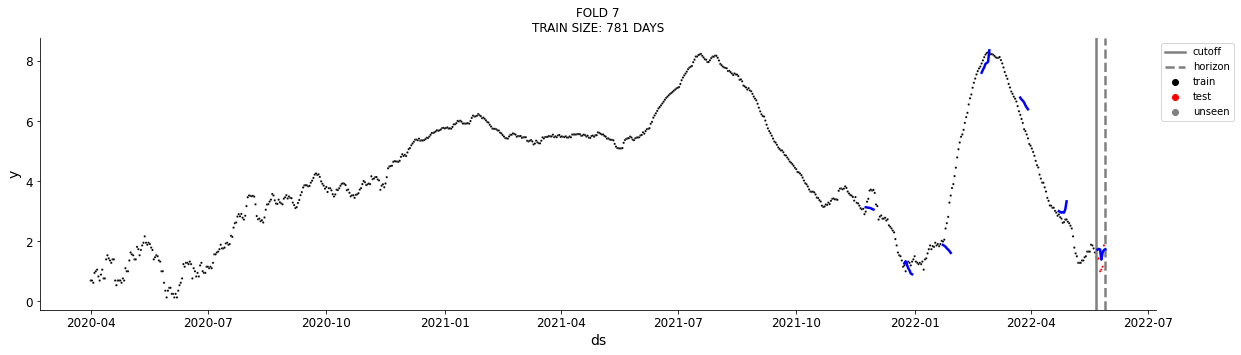

mape: 0.3090959740063789
mdape: 0.2306956944761372



In [ ]:
df_copy = df.copy()
df_cvf = bestmdape.drop('y', axis=1)
df_copy = df_copy.merge(df_cvf, how='left', on='ds')
df_cutoff_horizon = bestmdape.groupby('cutoff')[['ds']].max()

from sklearn.metrics import mean_absolute_percentage_error

for i, (cutoff, horizon) in enumerate(df_cutoff_horizon.iterrows()):
    horizon_cutoff = horizon['ds']
    df_copy['type'] = df_copy['ds'].apply(lambda date: 'train' if date < cutoff else
                                         'test' if date < horizon_cutoff else 'unseen')
    plt.figure(figsize=(20, 5))
    sns.scatterplot(x='ds', y='y', hue='type', s=5,
                   palette=['black', 'red', 'gray'],
                   data=df_copy)
    plt.axvline(x=cutoff, color='gray', label='cutoff')
    plt.axvline(x=horizon_cutoff, color='gray', ls='--', label='horizon')
    plt.plot(df_copy['ds'], df_copy['yhat'], color='b')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title(f"FOLD {i+1}\nTRAIN SIZE: {df_copy['type'].value_counts()['train']} DAYS")
    plt.show()
    cv_mape = bestmdape.groupby('cutoff').apply(lambda x: mean_absolute_percentage_error(y_true=x['y'],
                                                         y_pred=x['yhat']))
    cv_mdape = bestmdape.groupby('cutoff').apply(lambda x: mdape(y_true=x['y'],
                                                         y_pred=x['yhat']))
    print('mape:', cv_mape[i])
    print('mdape:', cv_mdape[i])
    print()